In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix, classification_report

import sys
sys.path.append('../lib/')
from blood_lib import learning_curves

import tensorflow as tf
import tensorflow_addons as tfa

2023-06-11 22:05:57.706228: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/nicolas/miniconda3/envs/tf_amd/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [5]:
path = '../Data/PBC_11cat_masked/'

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    image_size=(128, 128),
    labels='inferred',
    interpolation='bicubic',
    label_mode='categorical',
    validation_split=0.20,
    batch_size=32,
    subset='both',
    shuffle=True,
    seed=1
)
class_names = train_ds.class_names
num_classes = len(class_names)
train_ds, test_ds = tf.keras.utils.split_dataset(
    train_ds, left_size=0.8, seed=1)
print('train batch :', tf.data.Dataset.cardinality(train_ds).numpy())
print('val batch :', tf.data.Dataset.cardinality(val_ds).numpy())
print('test batch :', tf.data.Dataset.cardinality(test_ds).numpy())
print('classes :', class_names)
print('num_classes :', num_classes)


Found 16891 files belonging to 11 classes.
Using 13513 files for training.
Using 3378 files for validation.


2023-06-11 22:08:21.860625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [13513]
	 [[{{node Placeholder/_4}}]]
2023-06-11 22:08:21.861018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [13513]
	 [[{{node Placeholder/_0}}]]


train batch : 338
val batch : 106
test batch : 85
classes : ['BA', 'BNE', 'EO', 'ERB', 'LY', 'MMY', 'MO', 'MY', 'PLT', 'PMY', 'SNE']
num_classes : 11


In [6]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip(
            "horizontal_and_vertical", input_shape=(128, 128, 3)),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomBrightness(factor=0.001, value_range=(0, 255)),
        tf.keras.layers.RandomContrast(factor=0.1)
    ])


def process_images(ds, shuffle=1000, augment=False):
    """
    Apply diverse images modification in a tf.data.Dataset
    """
    # rescale
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    ds = ds.map(lambda x, y: (normalization_layer(x), y))
    # shuffle
    if shuffle != None:
        ds = ds.shuffle(shuffle)
    # augment
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y))
    return ds


train_ds = process_images(train_ds, shuffle=None, augment=False)
val_ds = process_images(val_ds, shuffle=None, augment=False)
test_ds = process_images(test_ds, shuffle=None, augment=False)


2023-06-11 22:08:41.079136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [10810,11]
	 [[{{node Placeholder/_1}}]]


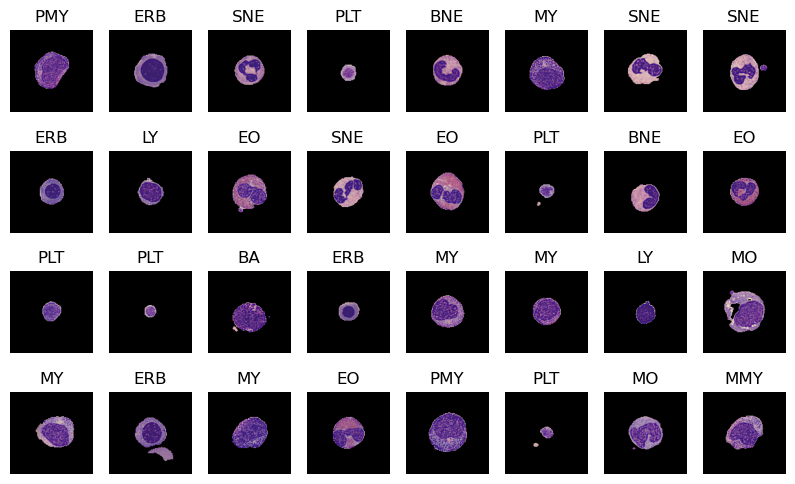

In [7]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 6))
for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow((image_batch[i].numpy() * 255).astype('uint8'))
    plt.title(class_names[np.argmax(label_batch[i])])
    plt.axis("off")


In [8]:
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime

model = tf.keras.Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs = 50
log_dir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             TensorBoard(log_dir=log_dir, histogram_freq=1),
             tfa.callbacks.TQDMProgressBar()]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks,
    verbose=0
)


Training:   0%|           0/50 ETA: ?s,  ?epochs/s

Epoch 1/50


0/338           ETA: ?s - 

2023-06-11 22:08:53.800682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-11 22:09:31.679071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3378]
	 [[{{node Placeholder/_4}}]]
2023-06-11 22:09:31.679469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3378]
	 [[{{node Placeholder/_4}}]]
2023-06-11 22:09:31.845425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 2/50


0/338           ETA: ?s - 

Epoch 3/50


0/338           ETA: ?s - 

Epoch 4/50


0/338           ETA: ?s - 

Epoch 5/50


0/338           ETA: ?s - 

Epoch 6/50


0/338           ETA: ?s - 

Epoch 7/50


0/338           ETA: ?s - 

Epoch 8/50


0/338           ETA: ?s - 

Epoch 9/50


0/338           ETA: ?s - 

Epoch 10/50


0/338           ETA: ?s - 

Epoch 11/50


0/338           ETA: ?s - 

In [9]:
print("Training accuracy:", history.history['accuracy'][-1])
print("Validation accuracy:", history.history['val_accuracy'][-1])
print("Training loss:", history.history['loss'][-1])
print("Validation loss:", history.history['val_loss'][-1])


Training accuracy: 0.9469010233879089
Validation accuracy: 0.8197157979011536
Training loss: 0.14397890865802765
Validation loss: 0.6381897330284119


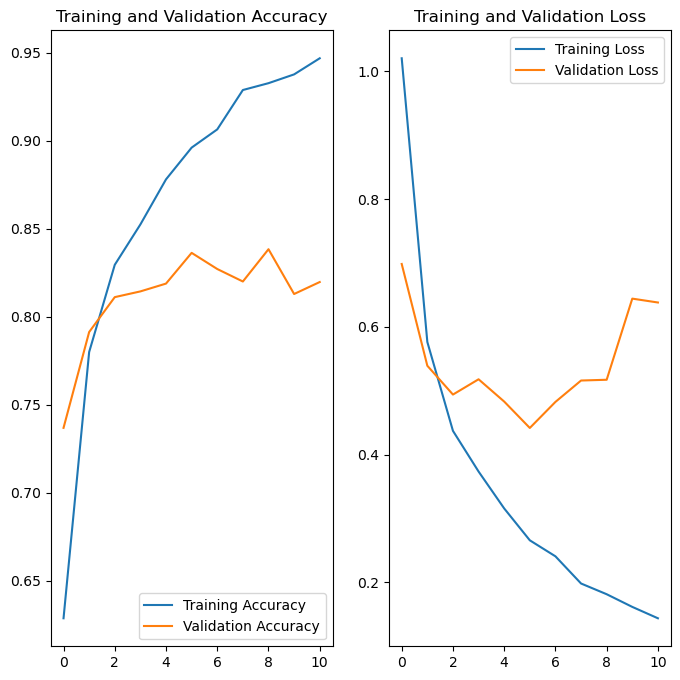

In [10]:
learning_curves(history)


2023-06-11 23:01:50.404334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [2703,11]
	 [[{{node Placeholder/_1}}]]
2023-06-11 23:01:50.537798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


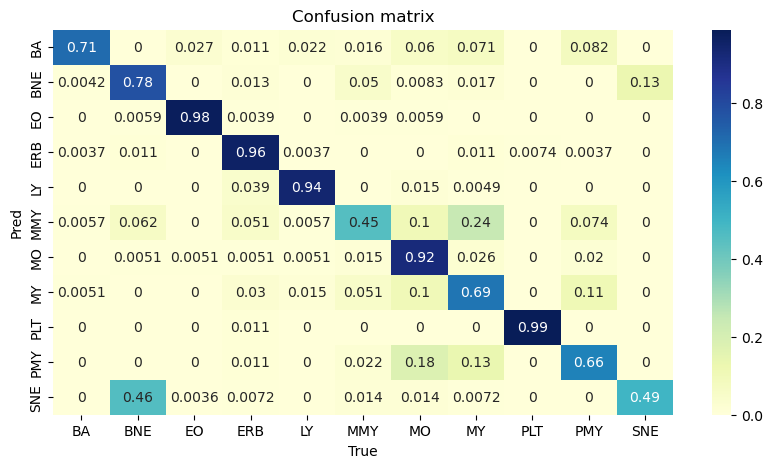

              precision    recall  f1-score   support

          BA       0.97      0.71      0.82       182
         BNE       0.56      0.78      0.65       240
          EO       0.99      0.98      0.98       508
         ERB       0.87      0.96      0.91       272
          LY       0.95      0.94      0.95       206
         MMY       0.69      0.45      0.55       176
          MO       0.70      0.92      0.79       196
          MY       0.62      0.69      0.65       197
         PLT       0.99      0.99      0.99       357
         PMY       0.52      0.66      0.58        90
         SNE       0.82      0.49      0.62       279

    accuracy                           0.82      2703
   macro avg       0.79      0.78      0.77      2703
weighted avg       0.83      0.82      0.82      2703



In [11]:
from sklearn.metrics import confusion_matrix
preds = model.predict(test_ds, batch_size=32, verbose=0)
preds = np.argmax(preds, axis=1)
true = np.concatenate([y for x, y in test_ds], axis=0)
true = np.argmax(true, axis=1)
preds_labels = [class_names[preds[x]] for x in range(len(preds))]
true_labels = [class_names[true[x]] for x in range(len(true))]

cm = confusion_matrix(true_labels, preds_labels, normalize='true')
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(10, 5))
plt.title("Confusion matrix")
sns.heatmap(cm_df, annot=True, cmap="YlGnBu")
plt.ylabel("Pred")
plt.xlabel("True")
plt.show()
CR = classification_report(true_labels, preds_labels)
print(CR)


In [12]:
model.save('Models/M0_PBC11_CNN3L_mask.h5')
with open('CR/CR_PBC11_CNN3L_mask.txt', 'w') as file:
    file.write(CR)
    file.close()
